In [303]:
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

#classifier and regression models to test
#classifier for feature selection
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor

from sklearn.svm import SVR
from xgboost import XGBRegressor

In [304]:
random_seed = np.random.seed(2021)

In [305]:
data = pd.read_csv('data_feat_extracted.csv', index_col=0)

In [306]:
data

,price,living_rooms,bedrooms,bathrooms,town_city,outward_code,property_type,tags
0,346000.0,1.0,1.0,1.0,Hayes,UB3,flat,none
1,343886.0,1.0,3.0,4.0,London,SW6,flat,furnished
2,260000.0,3.0,4.0,4.0,London,W1K,flat,none
3,260000.0,2.0,2.0,1.0,London,W1J,flat,located
4,238333.0,4.0,6.0,6.0,London,SW10,detached house,none
...,...,...,...,...,...,...,...,...
8163,19500.0,4.0,7.0,6.0,London,W8,town house,renovated
8164,19500.0,1.0,4.0,4.0,London,SW3,maisonette,none
8165,19500.0,4.0,8.0,6.0,London,W10,detached house,family
8166,19500.0,1.0,3.0,3.0,London,W11,property,none


In [307]:
dummies = pd.get_dummies(data)

In [308]:
X = dummies.drop('price', axis=1)
y = dummies['price']

In [309]:
#create train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)

In [310]:
steps = [('feature_selection', SelectFromModel(LogisticRegression())),
         ('pca', PCA()),
         ('xgbr_base_model', XGBRegressor()) 
]

In [311]:
pipe = Pipeline(steps=steps)

In [312]:
#StratifiedKFolk has the same test set for all splits; keep evaluating simple
cv = StratifiedKFold(n_splits=5, random_state=random_seed)

In [313]:
#import sklearn.metrics
#sorted(sklearn.metrics.SCORERS.keys())

In [314]:
n_scores = cross_val_score(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
preds = cross_val_predict(pipe, X_train, y_train, cv=cv)

/Users/michael/opt/anaconda3/envs/house_prices_proj/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/michael/opt/anaconda3/envs/house_prices_proj/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/michael/opt/anaconda3/envs/house_prices_proj/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/li

In [315]:
n_scores.mean()

-3680.0828331904654

In [316]:
print('XGBRegressor mae scores: {}'.format(n_scores))
print()
print('Tuned XGBRegressor mae avg scores: {}'.format(sum(n_scores)/len(n_scores)))

XGBRegressor mae scores: [-3866.81178807 -4084.75807627 -3440.3916729  -3314.78318593
 -3693.66944278]

Tuned XGBRegressor mae avg scores: -3680.0828331904654


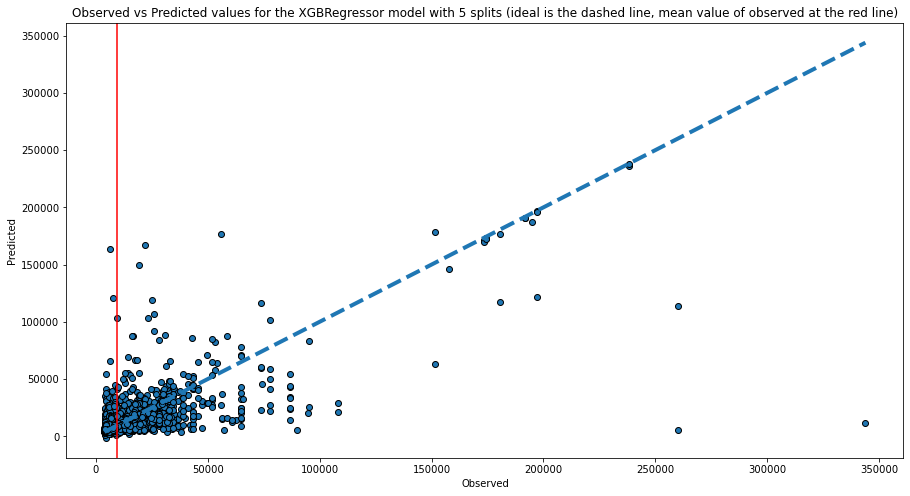

In [317]:
#XGBR plot

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(y_train, preds, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--', lw=4)

#mean
plt.axvline(x=y_train.mean(), color='r')

#labelling
ax.set_title('Observed vs Predicted values for the XGBRegressor model with 5 splits (ideal is the dashed line, mean value of observed at the red line)')
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')

plt.show()

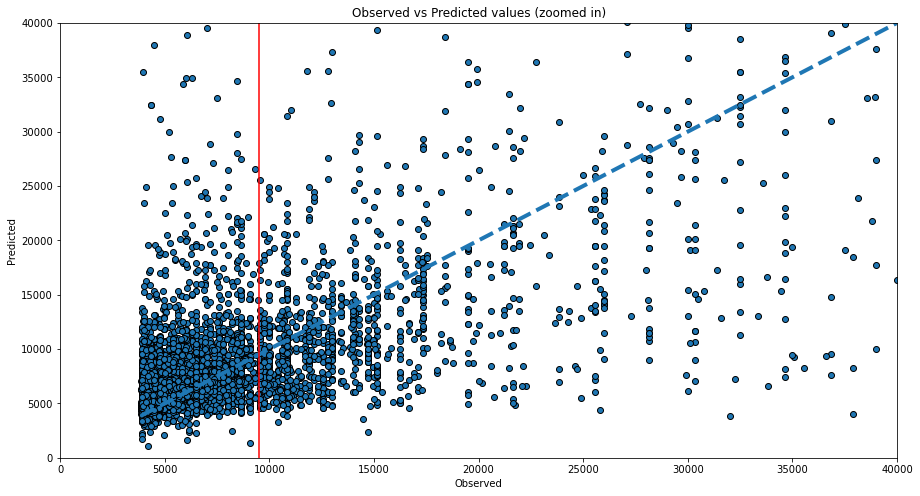

In [318]:
#XBGR zoomed in

fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(y_train, preds, edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--', lw=4)

#mean
plt.axvline(x=y_train.mean(), color='r')

#labelling
ax.set_title('Observed vs Predicted values (zoomed in)')
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')

plt.xlim(0, 40000)
plt.ylim(0, 40000)

plt.show()

In [320]:
#for HalvingRandomSearchCV only
xgbr = XGBRegressor()

In [321]:
search = GridSearchCV(xgbr, 
                      params, 
                      cv=cv, 
                      scoring='neg_mean_absolute_error'
                     )

In [322]:
#Run once

search_result = search.fit(X_train, y_train)

best_params = search_result.best_params_

/Users/michael/opt/anaconda3/envs/house_prices_proj/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


KeyboardInterrupt: 

'subsample': 0.5,
 'objective': 'reg:squarederror',
 'n_estimators': 200,
 'min_child_weight': 1,
 'max_depth': 7,
 'learning_rate': 0.01

best_params = {
    'subsample': 0.5,
    'objective': 'reg:squarederror',
    'n_estimators': 200,
    'min_child_weight': 1,
    'max_depth': 7,
    'learning_rate': 0.01
}

In [ ]:
tuned_steps = [('feature_selection', SelectFromModel(LogisticRegression())),
         ('pca', PCA()),
         ('tuned_xgbr_model', XGBRegressor(**best_params))
]

In [ ]:
tuned_pipe = Pipeline(steps=tuned_steps)

In [ ]:
tuned_n_scores = cross_val_score(tuned_pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
tuned_preds = cross_val_predict(tuned_pipe, X_train, y_train, cv=cv)

In [ ]:
print('Tuned XGBRegressor mae scores: {}'.format(tuned_n_scores))
print()
print('Tuned XGBRegressor mae avg scores: {}'.format(tuned_n_scores.mean()))